## Weighted Gaussian Process

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax.scipy.linalg import cholesky, solve_triangular
from typing import Callable, Tuple, NamedTuple
import optax

from qdax_es.utils.gaussian_processes.base_gp import rbf_kernel, GaussianProcess
from qdax_es.utils.gaussian_processes.weighted_gp import WeightedGaussianProcess

Matplotlib created a temporary cache directory at /tmp/matplotlib-qyacj8v0 because the default path (/home_nfs/paul/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Define the true function
def true_function(x):
    return jnp.sin(x[0]) + 0.5 * x[1]**2

n_samples = 1000
max_count = 1e5
# Generate training data
key = jax.random.PRNGKey(0)
X_train = jax.random.uniform(key, (n_samples, 2), minval=-3.0, maxval=3.0)
y_train = vmap(true_function)(X_train) + 0.1 * jax.random.normal(key, (n_samples,))

count = jax.random.randint(key, (n_samples,), minval=1, maxval=max_count)

# Normalize count
count_factor = jnp.where(
    count.max() > 1e3,
    1e3 / count.max(),
    1
)
count = count * count_factor
count = jnp.clip(count, 1e-3, 1e3)


size = count / count.max() * 20
weights = 1 / (count + 1e-6)  # Higher count means lower weight

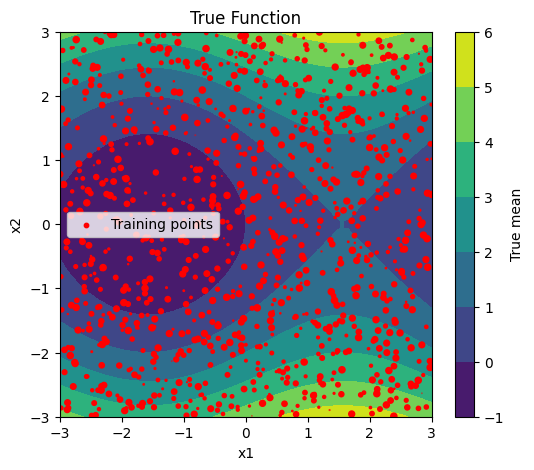

Mean Squared Error: 0.0060


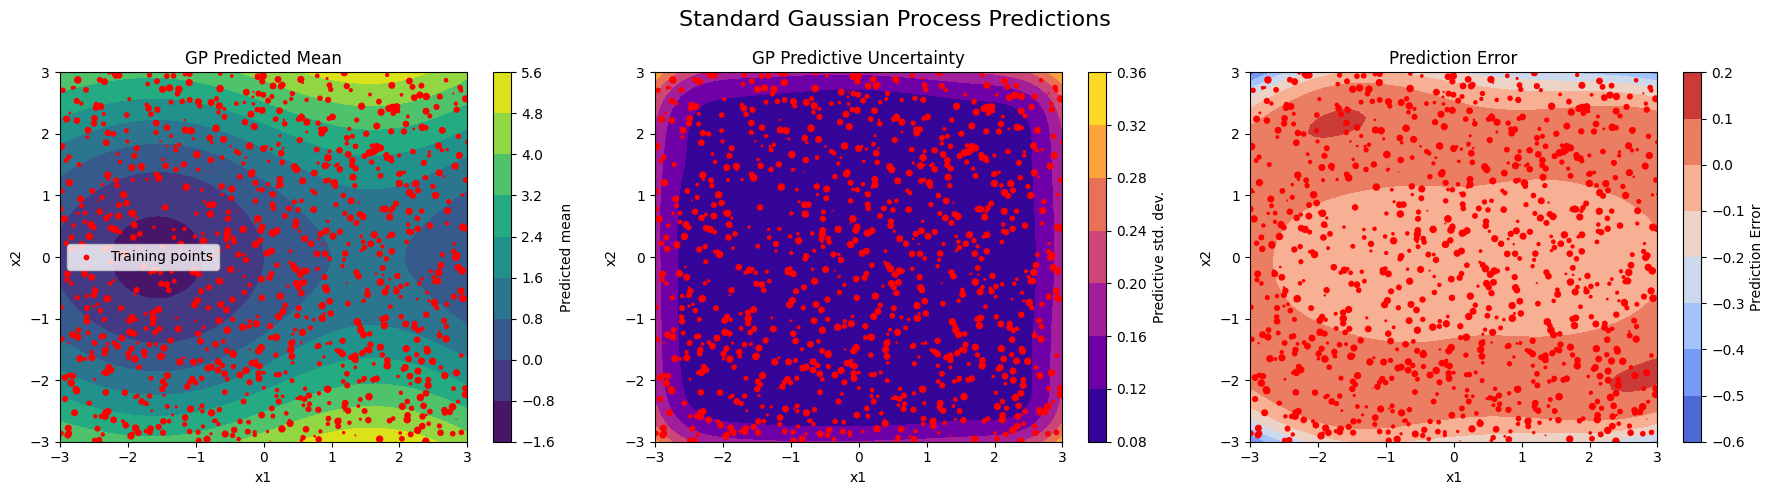

Weighted Mean Squared Error: 0.0024


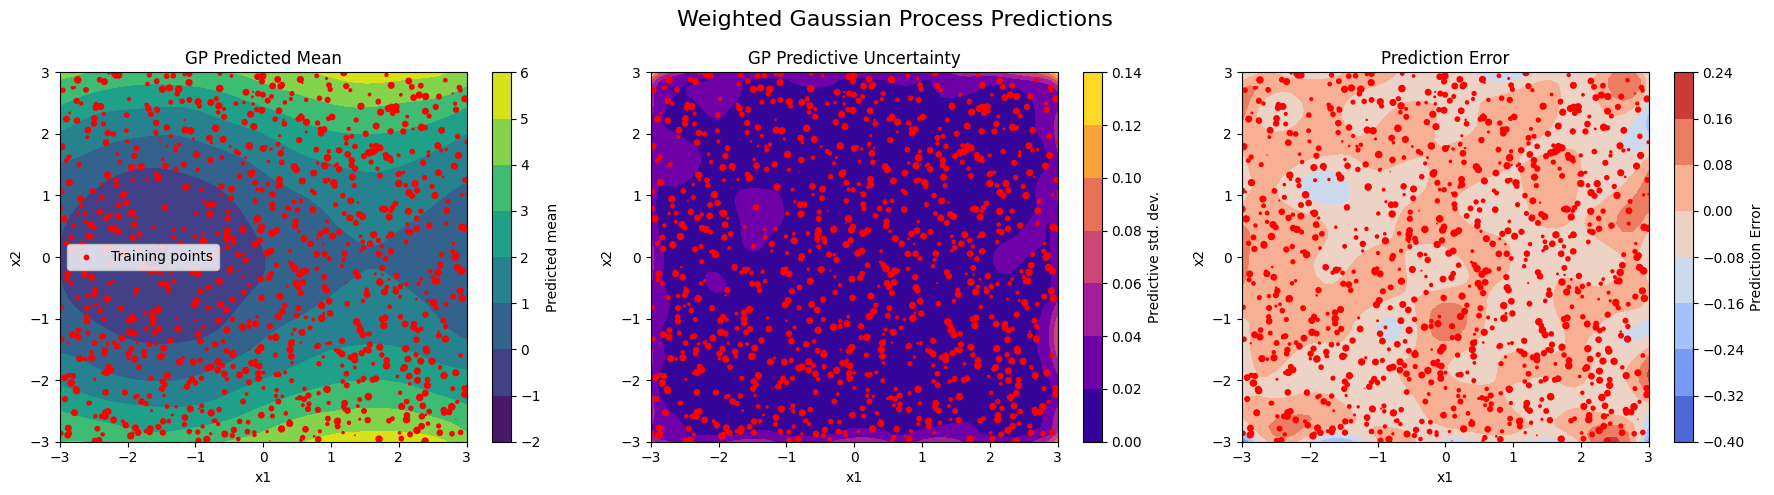

In [3]:

# Create 2D grid for prediction
x1 = jnp.linspace(-3.0, 3.0, 50)
x2 = jnp.linspace(-3.0, 3.0, 50)
X1, X2 = jnp.meshgrid(x1, x2)
X_grid = jnp.stack([X1.ravel(), X2.ravel()], axis=-1)

# Plot true function
X_true = jnp.stack([X1.ravel(), X2.ravel()], axis=-1)
y_true = vmap(true_function)(X_true)
y_true = np.array(y_true).reshape(50, 50)

# Plot true function
plt.figure(figsize=(6, 5))
plt.contourf(X1, X2, y_true, cmap='viridis')
plt.colorbar(label='True mean')
plt.title("True Function")
plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(np.array(X_train[:, 0]), np.array(X_train[:, 1]), c='r', s=size, label='Training points')
plt.legend()
plt.show()

## Standard GP

# Initialize GP
gp = GaussianProcess(rbf_kernel)

# Fit GP
params_opt = gp.fit(X_train, y_train, n_steps=500)

# Predict
mean, var = gp.predict(params_opt, X_train, y_train, X_grid)
mean = np.array(mean).reshape(50, 50)
std = np.sqrt(np.array(var)).reshape(50, 50)
error = mean - np.array(vmap(true_function)(X_grid)).reshape(50, 50)
mse = jnp.mean(error**2)
print(f"Mean Squared Error: {mse:.4f}")

# Plot mean prediction
plt.figure(figsize=(18, 5))
plt.suptitle("Standard Gaussian Process Predictions", fontsize=16)

plt.subplot(1, 3, 1)
plt.contourf(X1, X2, mean, cmap='viridis')
plt.colorbar(label='Predicted mean')
plt.scatter(np.array(X_train[:, 0]), np.array(X_train[:, 1]), c='r', s=size, label='Training points')
plt.title("GP Predicted Mean")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

# Plot predictive standard deviation
plt.subplot(1, 3, 2)
plt.contourf(X1, X2, std, cmap='plasma')
plt.colorbar(label='Predictive std. dev.')
plt.scatter(np.array(X_train[:, 0]), np.array(X_train[:, 1]), c='r', s=size)
plt.title("GP Predictive Uncertainty")
plt.xlabel("x1")
plt.ylabel("x2")

# Plot error
plt.subplot(1, 3, 3)
plt.contourf(X1, X2, error, cmap='coolwarm')
plt.colorbar(label='Prediction Error')
plt.scatter(np.array(X_train[:, 0]), np.array(X_train[:, 1]), c='r', s=size)
plt.title("Prediction Error")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()

## Weighted GP

# Initialize GP
weighted_gp = WeightedGaussianProcess(rbf_kernel)

# Fit GP
w_params_opt = weighted_gp.fit_weighted(X_train, y_train, weights, n_steps=500)

# Predict
mean, var = weighted_gp.predict(w_params_opt, X_train, y_train, X_grid)
mean = np.array(mean).reshape(50, 50)
std = np.sqrt(np.array(var)).reshape(50, 50)

# Compute error
error = mean - np.array(vmap(true_function)(X_grid)).reshape(50, 50)
mse = jnp.mean(error**2)
print(f"Weighted Mean Squared Error: {mse:.4f}")

# Plot mean prediction
plt.figure(figsize=(18, 5))
plt.suptitle("Weighted Gaussian Process Predictions", fontsize=16)

plt.subplot(1, 3, 1)
plt.contourf(X1, X2, mean, cmap='viridis')
plt.colorbar(label='Predicted mean')
plt.scatter(np.array(X_train[:, 0]), np.array(X_train[:, 1]), c='r', s=size, label='Training points')
plt.title("GP Predicted Mean")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

# Plot predictive standard deviation
plt.subplot(1, 3, 2)
plt.contourf(X1, X2, std, cmap='plasma')
plt.colorbar(label='Predictive std. dev.')
plt.scatter(np.array(X_train[:, 0]), np.array(X_train[:, 1]), c='r', s=size)
plt.title("GP Predictive Uncertainty")
plt.xlabel("x1")
plt.ylabel("x2")

# Plot error
plt.subplot(1, 3, 3)
plt.contourf(X1, X2, error, cmap='coolwarm')
plt.colorbar(label='Prediction Error')
plt.scatter(np.array(X_train[:, 0]), np.array(X_train[:, 1]), c='r', s=size)
plt.title("Prediction Error")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()